# V.A. Project

## Election timeout parameter evaluation

Experiment to verify what is the minimum timeout value for different system occupancies.

Run with version v4.1

In [1]:
# Library import

libFolder = "TR.AI.NS" # Library name

import sys, os
sys.path.append( os.path.join(os.path.dirname(sys.path[0])) + "/" + libFolder )


from Train import Train
from Client import Client, CliModes
from Network import Network

import csv
import numpy as np
from random import randint
import time
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd

In [80]:
# Setting the simulation conditions

# TODO!!! Escolher o mapa
mapPath = "../TR.AI.NS/map_grid"    # Map file path

cliDataFile = "datasets/normal_map-grid_60rep_2000iter.npz"

total_steps_run = -1              # Variable to limit the amount of simulation loops to be performed
total_clients_finished = 60       # Variable to limit the amount of clients to be delivered

simRepeat = 50                     # Number of times each simulation is repeated (to garner statistics)

trainSpeed = 20         # Speed the trains moves in the railway network the map (m/s)

logName = "/Volumes/Amy's HDD/TCC - TRAINS/log_simulation-timeout-v3.txt"     # Output log file. Stores all states of all trains and 
                                                # clients during each simulation loop

In [81]:
# Different frequency of clients to be analyzed
f_client = [25, 20, 15, 10, 5]

# Initial timeout values
init_timeout = [45, 45, 50, 50, 70]

# Number of trams
n_trams = 15    # The most extreme case seen, in the matter of number of messages exchanged

# Broadcast radius
cliR = 0.4      # Most of the time, the optimal parameter

# Simulation step speed
step_speed = 1

In [82]:
min_timeouts = {}

In [83]:
# Loading client creation dataset

client_dataset = np.load(cliDataFile)
client_creation = client_dataset.get("client")
client_position = client_dataset.get("init_stat")
client_destination = client_dataset.get("fin_stat")

In [84]:
# Auxiliary classes

class Simulation:
    def __init__(self):
        self.devices = []
        self.trainRange = 0
        self.clientRange = 0

Reading map file (../TR.AI.NS/map_grid)
	Going over graph info
	 - Map contains 81 vertices and 144 edges
	Going over vertices positions
	 - Got positions of the 81 vertices. 19 are stations
	Going over graph edges
	 - Read over 144 edges in graph


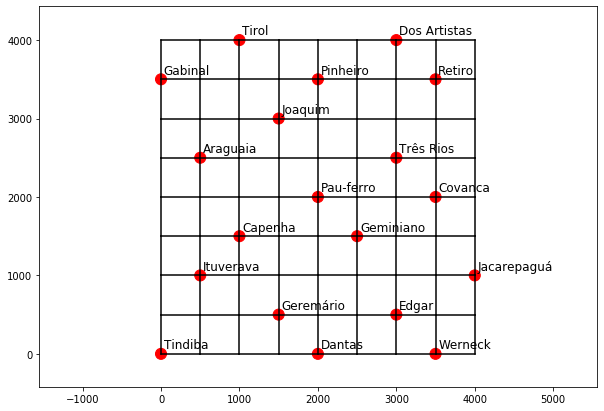

In [85]:
# Loading map

print("Reading map file (%s)" % mapPath)

# Getting CSV file names
graphInfo = "%s/Sheet 1-Graph Info.csv" % mapPath
vertices = "%s/Sheet 1-Vertices Positions.csv" % mapPath
connections = "%s/Sheet 1-Connection Matrix.csv" % mapPath


# Reading Graph Info table
print("\tGoing over graph info")

nVertices = 0
nEdges = 0
map_size = 0
with open(graphInfo) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            if not row[0] == "Number of vertices":
                raise Exception("Wrong input file format. See map input format")
            nVertices = int(row[1])
        elif line_count == 1:
            if not row[0] == "Number of connections":
                raise Exception("Wrong input file format. See map input format")
            nEdges = int(row[1])
        else:
            if not row[0] == "Map size":
                raise Exception("Wrong input file format. See map input format")
            map_size = float(row[1])
        line_count += 1
                                
    print("\t - Map contains %d vertices and %d edges" % (nVertices, nEdges))

# Reading Vertices Positions table
print("\tGoing over vertices positions")
                                
vert_pos = []
stoppingPoints = {}
stoppingPointsPos = []
with open(vertices) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = -1
    for row in csv_reader:
        if line_count == -1:
            line_count += 1
            continue
        vert_pos += [(float(row[1]), float(row[2]))]
        if row[0][0] != "_":
            stoppingPoints[row[0]] = line_count
            stoppingPointsPos += [(float(row[1]), float(row[2]))]
        line_count += 1
    if line_count != nVertices:
        raise Exception("Wrong input file format. The number of vertices given doesn't match the number of vertices specified")
    print("\t - Got positions of the %d vertices. %d are stations" %
          (nVertices, len(stoppingPoints.keys())))
                                
# Reading Connection Matrix table
print("\tGoing over graph edges")
                                
edges = np.ndarray(shape=(nVertices, nVertices), dtype=float)
edges.fill(-1)
                                
# Availability dictionary
availability = {}
                                
with open(connections) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    edge_count = 0
    for row in csv_reader:
        for i in range(nVertices):
            if row[i] != "":
                edges[line_count][i] = float(row[i])
                if line_count != i:
                    a = max(line_count, i)
                    b = min(line_count, i)
                    availability[ (a, b) ] = True
                if line_count > i:
                    edge_count += 1
        line_count += 1
    if nEdges != edge_count:
        raise Exception("Wrong input file format. Number of edges given doesn't match the specified number")
    print("\t - Read over %d edges in graph" % edge_count)

    
# Printing the map
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.axis('equal')

nEdgesDrawn = 0
for i in range(nVertices):
    for j in range(nVertices):
        if j >= i:
            break
        if edges[i][j] > 0:
            ax.plot([vert_pos[i][0], vert_pos[j][0]], [vert_pos[i][1], vert_pos[j][1]], 'k', zorder=-4)
            nEdgesDrawn += 1

xmin, xmax, ymin, ymax = ax.axis()
scale = (ymax-ymin) * .016  # Scale fator to print visible circles
for ponto in stoppingPoints.keys():
    pos = vert_pos[stoppingPoints[ponto]]
    c = plt.Circle(pos, radius=scale, color='r', zorder=-5)
    ax.add_patch(c)
    ax.text(pos[0] + scale*.5, pos[1] + scale, ponto, fontsize=12, wrap=True, zorder=-3)

xmin, xmax, ymin, ymax = ax.axis()
diverge = .05
xmin = xmin - (xmax - xmin) * diverge
xmax = xmax + (xmax - xmin) * diverge
ymin = ymin - (ymax - ymin) * diverge
ymax = ymax + (ymax - ymin) * diverge
ax.axis([xmin, xmax, ymin, ymax])

plt.show()

In [86]:
# logFile = open(logName, "w")

In [87]:
fIdx = 0

timeout = init_timeout[fIdx]

sim = Simulation()
net = Network(sim, log=False)
sim.clientRange = int(map_size * cliR)
sim.trainRange = 3 * sim.clientRange

try:
    while timeout >= 0:
        print("Timeout analysis for f_c = {}. Value: {}".format(f_client[fIdx], timeout))
        
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".
                            format(n_trams, cliR, turn+1))

            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating tram objects
            v_step = step_speed

            for i in range(n_trams):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                # Altering tram election timeout
                tr.nominalMaximumMsgWait = timeout     
                tr.maximumMsgWait = tr.nominalMaximumMsgWait / tr.vStep
                # NOTE: Should add a timeout update method!
                sim.devices += [tr]

            # Creating initial clients state
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation
            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % f_client[fIdx] == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*v_step
                            answerTime[client.id] = client.timeTillRequest*v_step
                            deliveryTime[client.id] = client.serviceTime*v_step

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"

            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]

            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value

            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]

            # TODO: Make version that is normalized by distance!

            print("Average total waiting time for {} trains: {}".format(n_trams, deliveryTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(deliveryTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

        print("\tTotal service time:\n", deliveryTimeList)
        # print("\tTotal distance traversed:\n", trainDistanceRun)
        print("\n\n")

        timeout = timeout - 5
        
except Exception as e:
    if (str(e) == "Client received two train assignments"):
        print()
        print("Found minimum timeout for f_c = {}: {}".format(f_client[fIdx], timeout))
        
        min_timeouts[f_client[fIdx]] = timeout

Timeout analysis for f_c = 25. Value: 45
Simulation with 15 trains, range 0.4. Turn 1
Finished simulation!
Average total waiting time for 15 trains: 359.98333333333335
Serviced 60 clients in 1865 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 282.0833333333333
Serviced 60 clients in 2006 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 343.21666666666664
Serviced 60 clients in 2223 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 297.0
Serviced 60 clients in 1964 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 322.28333333333336
Serviced 60 clients in 1922 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 tra

Finished simulation!
Average total waiting time for 15 trains: 315.3833333333333
Serviced 60 clients in 2438 simulation counts

Simulation with 15 trains, range 0.4. Turn 50
Finished simulation!
Average total waiting time for 15 trains: 407.1
Serviced 60 clients in 2008 simulation counts

	Total service time:
 [359.98333333333335, 282.0833333333333, 343.21666666666664, 297.0, 322.28333333333336, 309.0, 281.0833333333333, 313.9, 333.21666666666664, 270.76666666666665, 335.93333333333334, 342.06666666666666, 328.75, 279.95, 313.68333333333334, 321.53333333333336, 367.81666666666666, 290.65, 274.75, 317.6, 317.25, 246.83333333333334, 365.28333333333336, 304.3833333333333, 357.01666666666665, 291.2, 295.43333333333334, 438.6333333333333, 332.3, 256.68333333333334, 281.23333333333335, 310.65, 301.21666666666664, 317.78333333333336, 362.95, 295.6166666666667, 292.71666666666664, 348.3, 318.8333333333333, 286.48333333333335, 279.8833333333333, 284.2, 288.78333333333336, 398.7, 328.28333333333

Finished simulation!
Average total waiting time for 15 trains: 258.48333333333335
Serviced 60 clients in 2407 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 380.05
Serviced 60 clients in 1818 simulation counts

Simulation with 15 trains, range 0.4. Turn 45
Finished simulation!
Average total waiting time for 15 trains: 283.23333333333335
Serviced 60 clients in 1975 simulation counts

Simulation with 15 trains, range 0.4. Turn 46
Finished simulation!
Average total waiting time for 15 trains: 314.96666666666664
Serviced 60 clients in 2040 simulation counts

Simulation with 15 trains, range 0.4. Turn 47
Finished simulation!
Average total waiting time for 15 trains: 282.6166666666667
Serviced 60 clients in 2349 simulation counts

Simulation with 15 trains, range 0.4. Turn 48
Finished simulation!
Average total waiting time for 15 trains: 287.28333333333336
Serviced 60 clients in 1965 simulation counts

Simulatio

Finished simulation!
Average total waiting time for 15 trains: 261.51666666666665
Serviced 60 clients in 2321 simulation counts

Simulation with 15 trains, range 0.4. Turn 37
Finished simulation!
Average total waiting time for 15 trains: 285.98333333333335
Serviced 60 clients in 1864 simulation counts

Simulation with 15 trains, range 0.4. Turn 38
Finished simulation!
Average total waiting time for 15 trains: 311.7
Serviced 60 clients in 1762 simulation counts

Simulation with 15 trains, range 0.4. Turn 39
Finished simulation!
Average total waiting time for 15 trains: 279.3
Serviced 60 clients in 2169 simulation counts

Simulation with 15 trains, range 0.4. Turn 40
Finished simulation!
Average total waiting time for 15 trains: 298.95
Serviced 60 clients in 1853 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 272.8
Serviced 60 clients in 1668 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
F

Finished simulation!
Average total waiting time for 15 trains: 265.75
Serviced 60 clients in 1863 simulation counts

Simulation with 15 trains, range 0.4. Turn 31
Finished simulation!
Average total waiting time for 15 trains: 277.76666666666665
Serviced 60 clients in 1945 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Average total waiting time for 15 trains: 286.93333333333334
Serviced 60 clients in 1804 simulation counts

Simulation with 15 trains, range 0.4. Turn 33
Finished simulation!
Average total waiting time for 15 trains: 270.3666666666667
Serviced 60 clients in 1799 simulation counts

Simulation with 15 trains, range 0.4. Turn 34
Finished simulation!
Average total waiting time for 15 trains: 317.6333333333333
Serviced 60 clients in 2086 simulation counts

Simulation with 15 trains, range 0.4. Turn 35
Finished simulation!
Average total waiting time for 15 trains: 368.1333333333333
Serviced 60 clients in 1960 simulation counts

Simulation 

Finished simulation!
Average total waiting time for 15 trains: 356.6333333333333
Serviced 60 clients in 2569 simulation counts

Simulation with 15 trains, range 0.4. Turn 24
Finished simulation!
Average total waiting time for 15 trains: 254.48333333333332
Serviced 60 clients in 1908 simulation counts

Simulation with 15 trains, range 0.4. Turn 25
Finished simulation!
Average total waiting time for 15 trains: 339.73333333333335
Serviced 60 clients in 1624 simulation counts

Simulation with 15 trains, range 0.4. Turn 26
Finished simulation!
Average total waiting time for 15 trains: 282.48333333333335
Serviced 60 clients in 1732 simulation counts

Simulation with 15 trains, range 0.4. Turn 27
Finished simulation!
Average total waiting time for 15 trains: 278.73333333333335
Serviced 60 clients in 2223 simulation counts

Simulation with 15 trains, range 0.4. Turn 28
Finished simulation!
Average total waiting time for 15 trains: 379.71666666666664
Serviced 60 clients in 2266 simulation count

Finished simulation!
Average total waiting time for 15 trains: 270.31666666666666
Serviced 60 clients in 2142 simulation counts

Simulation with 15 trains, range 0.4. Turn 17
Finished simulation!
Average total waiting time for 15 trains: 332.75
Serviced 60 clients in 2184 simulation counts

Simulation with 15 trains, range 0.4. Turn 18
Finished simulation!
Average total waiting time for 15 trains: 263.93333333333334
Serviced 60 clients in 2093 simulation counts

Simulation with 15 trains, range 0.4. Turn 19
Finished simulation!
Average total waiting time for 15 trains: 220.6
Serviced 60 clients in 2069 simulation counts

Simulation with 15 trains, range 0.4. Turn 20
Finished simulation!
Average total waiting time for 15 trains: 319.6
Serviced 60 clients in 2398 simulation counts

Simulation with 15 trains, range 0.4. Turn 21
Finished simulation!
Average total waiting time for 15 trains: 307.85
Serviced 60 clients in 1803 simulation counts

Simulation with 15 trains, range 0.4. Turn 22


In [88]:
fIdx = 1

timeout = init_timeout[fIdx]

sim = Simulation()
net = Network(sim, log=False)
sim.clientRange = int(map_size * cliR)
sim.trainRange = 3 * sim.clientRange

try:
    while timeout >= 0:
        print("Timeout analysis for f_c = {}. Value: {}".format(f_client[fIdx], timeout))
        
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".
                            format(n_trams, cliR, turn+1))

            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating tram objects
            v_step = step_speed

            for i in range(n_trams):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                # Altering tram election timeout
                tr.nominalMaximumMsgWait = timeout     
                tr.maximumMsgWait = tr.nominalMaximumMsgWait / tr.vStep
                # NOTE: Should add a timeout update method!
                sim.devices += [tr]

            # Creating initial clients state
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation
            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % f_client[fIdx] == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*v_step
                            answerTime[client.id] = client.timeTillRequest*v_step
                            deliveryTime[client.id] = client.serviceTime*v_step

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"

            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]

            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value

            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]

            # TODO: Make version that is normalized by distance!

            print("Average total waiting time for {} trains: {}".format(n_trams, deliveryTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(deliveryTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

        print("\tTotal service time:\n", deliveryTimeList)
        # print("\tTotal distance traversed:\n", trainDistanceRun)
        print("\n\n")

        timeout = timeout - 5
        
except Exception as e:
    if (str(e) == "Client received two train assignments"):
        print()
        print("Found minimum timeout for f_c = {}: {}".format(f_client[fIdx], timeout))
        
        min_timeouts[f_client[fIdx]] = timeout

Timeout analysis for f_c = 20. Value: 45
Simulation with 15 trains, range 0.4. Turn 1
Finished simulation!
Average total waiting time for 15 trains: 283.3
Serviced 60 clients in 1660 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 340.53333333333336
Serviced 60 clients in 2143 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 525.0666666666667
Serviced 60 clients in 2450 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 304.9
Serviced 60 clients in 1742 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 329.4166666666667
Serviced 60 clients in 1981 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 396.61666

Finished simulation!
Average total waiting time for 15 trains: 360.28333333333336
Serviced 60 clients in 2008 simulation counts

Simulation with 15 trains, range 0.4. Turn 50
Finished simulation!
Average total waiting time for 15 trains: 379.45
Serviced 60 clients in 1827 simulation counts

	Total service time:
 [283.3, 340.53333333333336, 525.0666666666667, 304.9, 329.4166666666667, 396.6166666666667, 477.31666666666666, 331.56666666666666, 425.71666666666664, 305.3, 296.28333333333336, 375.7, 377.8666666666667, 328.8333333333333, 313.8333333333333, 294.96666666666664, 334.23333333333335, 333.25, 294.0, 362.76666666666665, 325.0, 389.9166666666667, 331.35, 313.8, 352.2, 435.18333333333334, 410.3333333333333, 399.46666666666664, 357.9166666666667, 354.05, 290.45, 340.31666666666666, 275.23333333333335, 370.1333333333333, 393.15, 317.96666666666664, 367.53333333333336, 302.28333333333336, 403.51666666666665, 339.15, 370.51666666666665, 337.76666666666665, 334.1, 350.68333333333334, 311.

Finished simulation!
Average total waiting time for 15 trains: 311.15
Serviced 60 clients in 1691 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 362.8333333333333
Serviced 60 clients in 1950 simulation counts

Simulation with 15 trains, range 0.4. Turn 45
Finished simulation!
Average total waiting time for 15 trains: 313.03333333333336
Serviced 60 clients in 1946 simulation counts

Simulation with 15 trains, range 0.4. Turn 46
Finished simulation!
Average total waiting time for 15 trains: 319.8
Serviced 60 clients in 1780 simulation counts

Simulation with 15 trains, range 0.4. Turn 47
Finished simulation!
Average total waiting time for 15 trains: 294.01666666666665
Serviced 60 clients in 1506 simulation counts

Simulation with 15 trains, range 0.4. Turn 48
Finished simulation!
Average total waiting time for 15 trains: 349.4
Serviced 60 clients in 1666 simulation counts

Simulation with 15 trains, range 0.

Finished simulation!
Average total waiting time for 15 trains: 378.0
Serviced 60 clients in 2047 simulation counts

Simulation with 15 trains, range 0.4. Turn 38
Finished simulation!
Average total waiting time for 15 trains: 267.3
Serviced 60 clients in 1533 simulation counts

Simulation with 15 trains, range 0.4. Turn 39
Finished simulation!
Average total waiting time for 15 trains: 374.98333333333335
Serviced 60 clients in 2073 simulation counts

Simulation with 15 trains, range 0.4. Turn 40
Finished simulation!
Average total waiting time for 15 trains: 348.85
Serviced 60 clients in 1583 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 391.75
Serviced 60 clients in 2350 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 373.21666666666664
Serviced 60 clients in 1949 simulation counts

Simulation with 15 trains, range 0.4. Turn 43


Finished simulation!
Average total waiting time for 15 trains: 281.1166666666667
Serviced 60 clients in 1736 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Average total waiting time for 15 trains: 295.48333333333335
Serviced 60 clients in 1816 simulation counts

Simulation with 15 trains, range 0.4. Turn 33
Finished simulation!
Average total waiting time for 15 trains: 278.76666666666665
Serviced 60 clients in 2420 simulation counts

Simulation with 15 trains, range 0.4. Turn 34
Finished simulation!
Average total waiting time for 15 trains: 304.6666666666667
Serviced 60 clients in 1463 simulation counts

Simulation with 15 trains, range 0.4. Turn 35
Finished simulation!
Average total waiting time for 15 trains: 371.35
Serviced 60 clients in 2256 simulation counts

Simulation with 15 trains, range 0.4. Turn 36
Finished simulation!
Average total waiting time for 15 trains: 286.95
Serviced 60 clients in 1744 simulation counts

Simulation with 15 tra

Finished simulation!
Average total waiting time for 15 trains: 304.35
Serviced 60 clients in 1741 simulation counts

Simulation with 15 trains, range 0.4. Turn 25
Finished simulation!
Average total waiting time for 15 trains: 329.95
Serviced 60 clients in 1803 simulation counts

Simulation with 15 trains, range 0.4. Turn 26
Finished simulation!
Average total waiting time for 15 trains: 367.0833333333333
Serviced 60 clients in 1707 simulation counts

Simulation with 15 trains, range 0.4. Turn 27
Finished simulation!
Average total waiting time for 15 trains: 371.26666666666665
Serviced 60 clients in 1806 simulation counts

Simulation with 15 trains, range 0.4. Turn 28
Finished simulation!
Average total waiting time for 15 trains: 341.68333333333334
Serviced 60 clients in 1849 simulation counts

Simulation with 15 trains, range 0.4. Turn 29
Finished simulation!
Average total waiting time for 15 trains: 393.81666666666666
Serviced 60 clients in 2272 simulation counts

Simulation with 15 tr

Finished simulation!
Average total waiting time for 15 trains: 271.05
Serviced 60 clients in 1769 simulation counts

Simulation with 15 trains, range 0.4. Turn 19
Finished simulation!
Average total waiting time for 15 trains: 298.51666666666665
Serviced 60 clients in 2288 simulation counts

Simulation with 15 trains, range 0.4. Turn 20
Finished simulation!
Average total waiting time for 15 trains: 368.31666666666666
Serviced 60 clients in 1793 simulation counts

Simulation with 15 trains, range 0.4. Turn 21
Finished simulation!
Average total waiting time for 15 trains: 281.0833333333333
Serviced 60 clients in 1901 simulation counts

Simulation with 15 trains, range 0.4. Turn 22
Finished simulation!
Average total waiting time for 15 trains: 274.28333333333336
Serviced 60 clients in 1730 simulation counts

Simulation with 15 trains, range 0.4. Turn 23
Finished simulation!
Average total waiting time for 15 trains: 312.4166666666667
Serviced 60 clients in 1809 simulation counts

Simulation

In [89]:
fIdx = 2

timeout = init_timeout[fIdx]

sim = Simulation()
net = Network(sim, log=False)
sim.clientRange = int(map_size * cliR)
sim.trainRange = 3 * sim.clientRange

try:
    while timeout >= 0:
        print("Timeout analysis for f_c = {}. Value: {}".format(f_client[fIdx], timeout))
        
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".
                            format(n_trams, cliR, turn+1))

            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating tram objects
            v_step = step_speed

            for i in range(n_trams):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                # Altering tram election timeout
                tr.nominalMaximumMsgWait = timeout     
                tr.maximumMsgWait = tr.nominalMaximumMsgWait / tr.vStep
                # NOTE: Should add a timeout update method!
                sim.devices += [tr]

            # Creating initial clients state
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation
            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % f_client[fIdx] == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*v_step
                            answerTime[client.id] = client.timeTillRequest*v_step
                            deliveryTime[client.id] = client.serviceTime*v_step

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"

            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]

            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value

            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]

            # TODO: Make version that is normalized by distance!

            print("Average total waiting time for {} trains: {}".format(n_trams, deliveryTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(deliveryTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

        print("\tTotal service time:\n", deliveryTimeList)
        print("\tTotal distance traversed:\n", trainDistanceRun)
        print("\n\n")

        timeout = timeout - 5
        
except Exception as e:
    if (str(e) == "Client received two train assignments"):
        print()
        print("Found minimum timeout for f_c = {}: {}".format(f_client[fIdx], timeout))
        
        min_timeouts[f_client[fIdx]] = timeout

Timeout analysis for f_c = 15. Value: 50
Simulation with 15 trains, range 0.4. Turn 1
Finished simulation!
Average total waiting time for 15 trains: 484.6666666666667
Serviced 60 clients in 2076 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 431.31666666666666
Serviced 60 clients in 2396 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 393.0
Serviced 60 clients in 1909 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 345.8
Serviced 60 clients in 1729 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 409.5833333333333
Serviced 60 clients in 1940 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 404.35
Se

Finished simulation!
Average total waiting time for 15 trains: 427.73333333333335
Serviced 60 clients in 2206 simulation counts

Simulation with 15 trains, range 0.4. Turn 50
Finished simulation!
Average total waiting time for 15 trains: 399.03333333333336
Serviced 60 clients in 2162 simulation counts

	Total service time:
 [484.6666666666667, 431.31666666666666, 393.0, 345.8, 409.5833333333333, 404.35, 408.46666666666664, 367.26666666666665, 330.85, 347.65, 335.51666666666665, 366.7, 410.01666666666665, 315.73333333333335, 376.05, 408.51666666666665, 368.03333333333336, 434.8666666666667, 465.6666666666667, 539.5666666666667, 363.1166666666667, 422.0, 385.53333333333336, 356.4, 459.28333333333336, 376.9166666666667, 304.01666666666665, 321.93333333333334, 330.7, 324.78333333333336, 336.53333333333336, 336.2, 383.73333333333335, 327.2, 339.3, 432.68333333333334, 395.06666666666666, 379.5, 304.95, 295.71666666666664, 371.1333333333333, 360.8, 316.53333333333336, 314.9166666666667, 400.2

Finished simulation!
Average total waiting time for 15 trains: 323.65
Serviced 60 clients in 1696 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 344.3333333333333
Serviced 60 clients in 1757 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 359.01666666666665
Serviced 60 clients in 1584 simulation counts

Simulation with 15 trains, range 0.4. Turn 43
Finished simulation!
Average total waiting time for 15 trains: 322.85
Serviced 60 clients in 1467 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 292.45
Serviced 60 clients in 1737 simulation counts

Simulation with 15 trains, range 0.4. Turn 45
Finished simulation!
Average total waiting time for 15 trains: 366.31666666666666
Serviced 60 clients in 1668 simulation counts

Simulation with 15 trains, range 

Finished simulation!
Average total waiting time for 15 trains: 311.7
Serviced 60 clients in 1671 simulation counts

Simulation with 15 trains, range 0.4. Turn 31
Finished simulation!
Average total waiting time for 15 trains: 283.1166666666667
Serviced 60 clients in 1797 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Average total waiting time for 15 trains: 357.21666666666664
Serviced 60 clients in 1858 simulation counts

Simulation with 15 trains, range 0.4. Turn 33
Finished simulation!
Average total waiting time for 15 trains: 348.0833333333333
Serviced 60 clients in 1615 simulation counts

Simulation with 15 trains, range 0.4. Turn 34
Finished simulation!
Average total waiting time for 15 trains: 342.98333333333335
Serviced 60 clients in 1451 simulation counts

Simulation with 15 trains, range 0.4. Turn 35
Finished simulation!
Average total waiting time for 15 trains: 306.8333333333333
Serviced 60 clients in 1681 simulation counts

Simulation w

Finished simulation!
Average total waiting time for 15 trains: 306.43333333333334
Serviced 60 clients in 1725 simulation counts

Simulation with 15 trains, range 0.4. Turn 22
Finished simulation!
Average total waiting time for 15 trains: 412.6166666666667
Serviced 60 clients in 1848 simulation counts

Simulation with 15 trains, range 0.4. Turn 23
Finished simulation!
Average total waiting time for 15 trains: 345.46666666666664
Serviced 60 clients in 1599 simulation counts

Simulation with 15 trains, range 0.4. Turn 24
Finished simulation!
Average total waiting time for 15 trains: 324.6
Serviced 60 clients in 1913 simulation counts

Simulation with 15 trains, range 0.4. Turn 25
Finished simulation!
Average total waiting time for 15 trains: 363.8333333333333
Serviced 60 clients in 1742 simulation counts

Simulation with 15 trains, range 0.4. Turn 26
Finished simulation!
Average total waiting time for 15 trains: 452.23333333333335
Serviced 60 clients in 2185 simulation counts

Simulation 

Finished simulation!
Average total waiting time for 15 trains: 426.35
Serviced 60 clients in 1984 simulation counts

Simulation with 15 trains, range 0.4. Turn 13
Finished simulation!
Average total waiting time for 15 trains: 344.7
Serviced 60 clients in 1792 simulation counts

Simulation with 15 trains, range 0.4. Turn 14
Finished simulation!
Average total waiting time for 15 trains: 298.68333333333334
Serviced 60 clients in 1566 simulation counts

Simulation with 15 trains, range 0.4. Turn 15
Finished simulation!
Average total waiting time for 15 trains: 323.01666666666665
Serviced 60 clients in 1761 simulation counts

Simulation with 15 trains, range 0.4. Turn 16
Finished simulation!
Average total waiting time for 15 trains: 335.0
Serviced 60 clients in 1640 simulation counts

Simulation with 15 trains, range 0.4. Turn 17
Finished simulation!
Average total waiting time for 15 trains: 397.8666666666667
Serviced 60 clients in 1498 simulation counts

Simulation with 15 trains, range 0.

Finished simulation!
Average total waiting time for 15 trains: 416.3333333333333
Serviced 60 clients in 2177 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 288.78333333333336
Serviced 60 clients in 1554 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 501.26666666666665
Serviced 60 clients in 2500 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 360.73333333333335
Serviced 60 clients in 1842 simulation counts

Simulation with 15 trains, range 0.4. Turn 7
Finished simulation!
Average total waiting time for 15 trains: 379.96666666666664
Serviced 60 clients in 1833 simulation counts

Simulation with 15 trains, range 0.4. Turn 8
Finished simulation!
Average total waiting time for 15 trains: 381.0
Serviced 60 clients in 2105 simulation counts

Simulation with

Finished simulation!
Average total waiting time for 15 trains: 415.75
Serviced 60 clients in 2028 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 381.98333333333335
Serviced 60 clients in 1847 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 330.96666666666664
Serviced 60 clients in 1744 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 342.53333333333336
Serviced 60 clients in 1757 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 405.6166666666667
Serviced 60 clients in 1795 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 405.1333333333333
Serviced 60 clients in 1971 simulation counts

Simulation with

In [90]:
fIdx = 3

timeout = init_timeout[fIdx]

sim = Simulation()
net = Network(sim, log=False)
sim.clientRange = int(map_size * cliR)
sim.trainRange = 3 * sim.clientRange

try:
    while timeout >= 0:
        print("Timeout analysis for f_c = {}. Value: {}".format(f_client[fIdx], timeout))
        
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".
                            format(n_trams, cliR, turn+1))

            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating tram objects
            v_step = step_speed

            for i in range(n_trams):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                # Altering tram election timeout
                tr.nominalMaximumMsgWait = timeout     
                tr.maximumMsgWait = tr.nominalMaximumMsgWait / tr.vStep
                # NOTE: Should add a timeout update method!
                sim.devices += [tr]

            # Creating initial clients state
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation
            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % f_client[fIdx] == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*v_step
                            answerTime[client.id] = client.timeTillRequest*v_step
                            deliveryTime[client.id] = client.serviceTime*v_step

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"

            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]

            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value

            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]

            # TODO: Make version that is normalized by distance!

            print("Average total waiting time for {} trains: {}".format(n_trams, deliveryTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(deliveryTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

        print("\tTotal service time:\n", deliveryTimeList)
        print("\tTotal distance traversed:\n", trainDistanceRun)
        print("\n\n")

        timeout = timeout - 5
        
except Exception as e:
    if (str(e) == "Client received two train assignments"):
        print()
        print("Found minimum timeout for f_c = {}: {}".format(f_client[fIdx], timeout))
        
        min_timeouts[f_client[fIdx]] = timeout

Timeout analysis for f_c = 10. Value: 50
Simulation with 15 trains, range 0.4. Turn 1
Finished simulation!
Average total waiting time for 15 trains: 513.9166666666666
Serviced 60 clients in 1549 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 506.18333333333334
Serviced 60 clients in 1731 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 593.1333333333333
Serviced 60 clients in 1872 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 491.6
Serviced 60 clients in 1754 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 487.4
Serviced 60 clients in 1753 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 505.98333

Finished simulation!
Average total waiting time for 15 trains: 474.0
Serviced 60 clients in 1685 simulation counts

Simulation with 15 trains, range 0.4. Turn 50
Finished simulation!
Average total waiting time for 15 trains: 462.45
Serviced 60 clients in 2102 simulation counts

	Total service time:
 [513.9166666666666, 506.18333333333334, 593.1333333333333, 491.6, 487.4, 505.98333333333335, 630.6166666666667, 494.85, 441.1666666666667, 490.3, 484.1166666666667, 541.5666666666667, 465.71666666666664, 524.8833333333333, 497.01666666666665, 465.51666666666665, 488.06666666666666, 479.25, 430.98333333333335, 513.5833333333334, 494.6, 502.75, 510.0833333333333, 533.3, 573.5833333333334, 477.4166666666667, 513.7166666666667, 454.1666666666667, 496.96666666666664, 471.96666666666664, 436.05, 623.95, 533.6666666666666, 526.4333333333333, 448.96666666666664, 551.1666666666666, 410.6333333333333, 497.78333333333336, 480.9166666666667, 462.65, 441.6666666666667, 595.1166666666667, 412.8, 615.0666

Finished simulation!
Average total waiting time for 15 trains: 485.96666666666664
Serviced 60 clients in 1691 simulation counts

Simulation with 15 trains, range 0.4. Turn 40
Finished simulation!
Average total waiting time for 15 trains: 483.46666666666664
Serviced 60 clients in 1661 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 443.3666666666667
Serviced 60 clients in 1847 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 592.7166666666667
Serviced 60 clients in 1979 simulation counts

Simulation with 15 trains, range 0.4. Turn 43
Finished simulation!
Average total waiting time for 15 trains: 361.26666666666665
Serviced 60 clients in 1331 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 597.1333333333333
Serviced 60 clients in 1872 simulation counts


Finished simulation!
Average total waiting time for 15 trains: 528.1666666666666
Serviced 60 clients in 1735 simulation counts

Simulation with 15 trains, range 0.4. Turn 30
Finished simulation!
Average total waiting time for 15 trains: 504.68333333333334
Serviced 60 clients in 2038 simulation counts

Simulation with 15 trains, range 0.4. Turn 31
Finished simulation!
Average total waiting time for 15 trains: 462.3666666666667
Serviced 60 clients in 1918 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Average total waiting time for 15 trains: 493.8666666666667
Serviced 60 clients in 1783 simulation counts

Simulation with 15 trains, range 0.4. Turn 33
Finished simulation!
Average total waiting time for 15 trains: 529.5333333333333
Serviced 60 clients in 1832 simulation counts

Simulation with 15 trains, range 0.4. Turn 34
Finished simulation!
Average total waiting time for 15 trains: 443.8833333333333
Serviced 60 clients in 1455 simulation counts

S

Finished simulation!
Average total waiting time for 15 trains: 450.93333333333334
Serviced 60 clients in 1729 simulation counts

Simulation with 15 trains, range 0.4. Turn 20
Finished simulation!
Average total waiting time for 15 trains: 490.48333333333335
Serviced 60 clients in 1816 simulation counts

Simulation with 15 trains, range 0.4. Turn 21
Finished simulation!
Average total waiting time for 15 trains: 518.7166666666667
Serviced 60 clients in 1890 simulation counts

Simulation with 15 trains, range 0.4. Turn 22
Finished simulation!
Average total waiting time for 15 trains: 453.26666666666665
Serviced 60 clients in 1610 simulation counts

Simulation with 15 trains, range 0.4. Turn 23
Finished simulation!
Average total waiting time for 15 trains: 500.85
Serviced 60 clients in 1876 simulation counts

Simulation with 15 trains, range 0.4. Turn 24
Finished simulation!
Average total waiting time for 15 trains: 478.68333333333334
Serviced 60 clients in 1761 simulation counts

Simulatio

Finished simulation!
Average total waiting time for 15 trains: 413.25
Serviced 60 clients in 1587 simulation counts

Simulation with 15 trains, range 0.4. Turn 10
Finished simulation!
Average total waiting time for 15 trains: 428.55
Serviced 60 clients in 1514 simulation counts

Simulation with 15 trains, range 0.4. Turn 11
Finished simulation!
Average total waiting time for 15 trains: 451.9
Serviced 60 clients in 1797 simulation counts

Simulation with 15 trains, range 0.4. Turn 12
Finished simulation!
Average total waiting time for 15 trains: 500.48333333333335
Serviced 60 clients in 1839 simulation counts

Simulation with 15 trains, range 0.4. Turn 13
Finished simulation!
Average total waiting time for 15 trains: 403.6
Serviced 60 clients in 1454 simulation counts

Simulation with 15 trains, range 0.4. Turn 14
Finished simulation!
Average total waiting time for 15 trains: 521.2333333333333
Serviced 60 clients in 1740 simulation counts

Simulation with 15 trains, range 0.4. Turn 15
F

Finished simulation!
Average total waiting time for 15 trains: 498.31666666666666
Serviced 60 clients in 1625 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 555.55
Serviced 60 clients in 2135 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 570.3833333333333
Serviced 60 clients in 2099 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 431.98333333333335
Serviced 60 clients in 1610 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 469.46666666666664
Serviced 60 clients in 2222 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 525.1
Serviced 60 clients in 1838 simulation counts

Simulation with 15 trains, 

Finished simulation!
Average total waiting time for 15 trains: 389.8833333333333
Serviced 60 clients in 1568 simulation counts

	Total service time:
 [498.31666666666666, 555.55, 570.3833333333333, 431.98333333333335, 469.46666666666664, 525.1, 523.8, 454.78333333333336, 446.3666666666667, 445.8333333333333, 536.55, 596.4666666666667, 403.25, 459.3, 487.1166666666667, 424.01666666666665, 523.8333333333334, 518.9333333333333, 453.3666666666667, 440.2, 449.48333333333335, 482.75, 528.9, 447.46666666666664, 551.6833333333333, 513.8833333333333, 481.56666666666666, 440.85, 456.18333333333334, 467.23333333333335, 400.15, 517.7166666666667, 455.9166666666667, 402.9, 393.23333333333335, 474.6666666666667, 371.78333333333336, 531.3333333333334, 418.1333333333333, 525.8166666666667, 364.98333333333335, 507.85, 476.85, 553.7833333333333, 445.06666666666666, 576.8166666666667, 557.5666666666667, 505.6, 357.85, 389.8833333333333]
	Total distance traversed:
 [254000.0, 283000.0, 294000.0, 251000.0,

In [94]:
fIdx = 4

f_client[fIdx] = 5
timeout = init_timeout[fIdx]

sim = Simulation()
net = Network(sim, log=False)
sim.clientRange = int(map_size * cliR)
sim.trainRange = 3 * sim.clientRange

try:
    while timeout >= 0:
        print("Timeout analysis for f_c = {}. Value: {}".format(f_client[fIdx], timeout))
        
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".
                            format(n_trams, cliR, turn+1))

            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating tram objects
            v_step = step_speed

            for i in range(n_trams):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                # Altering tram election timeout
                tr.nominalMaximumMsgWait = timeout     
                tr.maximumMsgWait = tr.nominalMaximumMsgWait / tr.vStep
                # NOTE: Should add a timeout update method!
                sim.devices += [tr]

            # Creating initial clients state
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation
            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % f_client[fIdx] == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*v_step
                            answerTime[client.id] = client.timeTillRequest*v_step
                            deliveryTime[client.id] = client.serviceTime*v_step

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"

            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]

            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value

            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]

            # TODO: Make version that is normalized by distance!

            print("Average total waiting time for {} trains: {}".format(n_trams, deliveryTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(deliveryTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

        print("\tTotal service time:\n", deliveryTimeList)
        print("\tTotal distance traversed:\n", trainDistanceRun)
        print("\n\n")

        timeout = timeout - 5
        
except Exception as e:
    if (str(e) == "Client received two train assignments"):
        print()
        print("Found minimum timeout for f_c = {}: {}".format(f_client[fIdx], timeout))
        
        min_timeouts[f_client[fIdx]] = timeout

Timeout analysis for f_c = 5. Value: 70
Simulation with 15 trains, range 0.4. Turn 1
Finished simulation!
Average total waiting time for 15 trains: 643.9833333333333
Serviced 60 clients in 1635 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 702.6
Serviced 60 clients in 1947 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 728.8
Serviced 60 clients in 1775 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 754.4666666666667
Serviced 60 clients in 1935 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 673.4666666666667
Serviced 60 clients in 1778 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 654.3666666

Finished simulation!
Average total waiting time for 15 trains: 664.4833333333333
Serviced 60 clients in 1713 simulation counts

Simulation with 15 trains, range 0.4. Turn 50
Finished simulation!
Average total waiting time for 15 trains: 599.5
Serviced 60 clients in 1667 simulation counts

	Total service time:
 [643.9833333333333, 702.6, 728.8, 754.4666666666667, 673.4666666666667, 654.3666666666667, 692.6, 627.3333333333334, 659.2166666666667, 669.3833333333333, 718.2666666666667, 591.7666666666667, 635.0833333333334, 675.3166666666667, 660.0833333333334, 704.1333333333333, 679.9333333333333, 710.2, 625.2, 675.9666666666667, 627.5166666666667, 645.7833333333333, 676.35, 707.25, 692.6333333333333, 725.3, 648.2333333333333, 641.6166666666667, 700.6833333333333, 644.15, 681.05, 637.8333333333334, 613.8333333333334, 635.7666666666667, 648.5333333333333, 719.4, 653.7166666666667, 734.8666666666667, 670.85, 671.85, 645.2833333333333, 603.7666666666667, 624.9333333333333, 726.9666666666667, 6

Finished simulation!
Average total waiting time for 15 trains: 648.7333333333333
Serviced 60 clients in 1853 simulation counts

Simulation with 15 trains, range 0.4. Turn 40
Finished simulation!
Average total waiting time for 15 trains: 620.6333333333333
Serviced 60 clients in 1661 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 654.2333333333333
Serviced 60 clients in 1925 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 597.9166666666666
Serviced 60 clients in 1647 simulation counts

Simulation with 15 trains, range 0.4. Turn 43
Finished simulation!
Average total waiting time for 15 trains: 595.6666666666666
Serviced 60 clients in 1623 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 685.3333333333334
Serviced 60 clients in 1762 simulation counts

Si

Finished simulation!
Average total waiting time for 15 trains: 639.3833333333333
Serviced 60 clients in 1702 simulation counts

Simulation with 15 trains, range 0.4. Turn 30
Finished simulation!
Average total waiting time for 15 trains: 602.2833333333333
Serviced 60 clients in 1640 simulation counts

Simulation with 15 trains, range 0.4. Turn 31
Finished simulation!
Average total waiting time for 15 trains: 626.1666666666666
Serviced 60 clients in 1616 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Average total waiting time for 15 trains: 656.35
Serviced 60 clients in 2285 simulation counts

Simulation with 15 trains, range 0.4. Turn 33
Finished simulation!
Average total waiting time for 15 trains: 628.65
Serviced 60 clients in 1926 simulation counts

Simulation with 15 trains, range 0.4. Turn 34
Finished simulation!
Average total waiting time for 15 trains: 632.4833333333333
Serviced 60 clients in 1654 simulation counts

Simulation with 15 train

Finished simulation!
Average total waiting time for 15 trains: 625.4666666666667
Serviced 60 clients in 1825 simulation counts

Simulation with 15 trains, range 0.4. Turn 21
Finished simulation!
Average total waiting time for 15 trains: 552.0333333333333
Serviced 60 clients in 1361 simulation counts

Simulation with 15 trains, range 0.4. Turn 22
Finished simulation!
Average total waiting time for 15 trains: 672.7666666666667
Serviced 60 clients in 1717 simulation counts

Simulation with 15 trains, range 0.4. Turn 23
Finished simulation!
Average total waiting time for 15 trains: 604.1
Serviced 60 clients in 1469 simulation counts

Simulation with 15 trains, range 0.4. Turn 24
Finished simulation!
Average total waiting time for 15 trains: 695.0666666666667
Serviced 60 clients in 1674 simulation counts

Simulation with 15 trains, range 0.4. Turn 25
Finished simulation!
Average total waiting time for 15 trains: 678.3166666666667
Serviced 60 clients in 1821 simulation counts

Simulation wit

Finished simulation!
Average total waiting time for 15 trains: 688.2
Serviced 60 clients in 1744 simulation counts

Simulation with 15 trains, range 0.4. Turn 12
Finished simulation!
Average total waiting time for 15 trains: 608.5666666666667
Serviced 60 clients in 1720 simulation counts

Simulation with 15 trains, range 0.4. Turn 13
Finished simulation!
Average total waiting time for 15 trains: 621.6833333333333
Serviced 60 clients in 1787 simulation counts

Simulation with 15 trains, range 0.4. Turn 14
Finished simulation!
Average total waiting time for 15 trains: 619.95
Serviced 60 clients in 1601 simulation counts

Simulation with 15 trains, range 0.4. Turn 15
Finished simulation!
Average total waiting time for 15 trains: 639.3666666666667
Serviced 60 clients in 1762 simulation counts

Simulation with 15 trains, range 0.4. Turn 16
Finished simulation!
Average total waiting time for 15 trains: 639.5333333333333
Serviced 60 clients in 1624 simulation counts

Simulation with 15 trains

Finished simulation!
Average total waiting time for 15 trains: 647.35
Serviced 60 clients in 1748 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 741.75
Serviced 60 clients in 1883 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 701.9333333333333
Serviced 60 clients in 1893 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 609.5166666666667
Serviced 60 clients in 1689 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 636.1
Serviced 60 clients in 1667 simulation counts

Simulation with 15 trains, range 0.4. Turn 7
Finished simulation!
Average total waiting time for 15 trains: 724.25
Serviced 60 clients in 1724 simulation counts

Simulation with 15 trains, range 0.4. Turn 8
Finishe

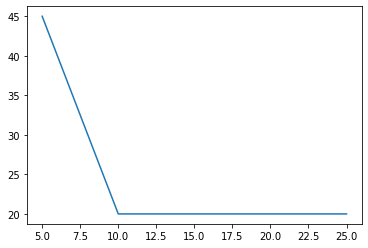

In [95]:
plt.plot(list(min_timeouts.keys()), list(min_timeouts.values()))

In [96]:
min_timeouts

{25: 20, 20: 20, 15: 20, 10: 20, 5: 45}